In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# import the data covert that into a convenient data
PATH= '/home/ac-optimus/data_science/recommendation_sys/ratings_small.csv'
df = pd.read_csv(PATH, sep= ",")
# df = pd.read_csv(PATH, sep= ",")
df.shape

(100004, 4)

In [4]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [5]:
# this gave me a good plot
from sklearn.utils import shuffle
df = shuffle(df)

In [6]:
df.head()

,userId,movieId,rating
47840,353,170,2.0
65165,463,3555,3.0
47403,346,8636,4.5
85804,575,1907,3.0
64852,463,296,3.0


In [7]:
num_rows = df.shape[0]
train, test = df.copy(deep = True), df[int(num_rows*0.8):].copy(deep = True)
train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0
train = shuffle(train)

<ipython-input-7-75ff325d5135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0


In [8]:
user_movie_rating =train.groupby(['userId','movieId'])['rating'].max().unstack().fillna(0)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
user_movie_rating.shape
print ("We have {} users in our user-movie matrix.".format(user_movie_rating.shape[0]))
print ("We have {} movies in our user-movie matrix.".format(user_movie_rating.shape[1]))


We have 671 users in our user-movie matrix.
We have 9066 movies in our user-movie matrix.


In [10]:
correlation_matrix = user_movie_rating.corr()
correlation_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.148708,0.133250,0.065697,0.099806,0.161984,0.114037,-0.013158,-0.022728,0.060894,...,NaN,-0.024034,NaN,0.081303,0.081303,0.081303,0.081303,-0.024034,NaN,NaN
2,0.148708,1.000000,0.124496,0.057518,0.129719,0.079546,0.056148,0.202766,0.002641,0.266273,...,NaN,0.049842,NaN,0.081830,0.081830,0.145807,-0.014135,-0.014135,NaN,NaN
3,0.133250,0.124496,1.000000,0.197163,0.376749,0.131445,0.277487,0.121576,0.132958,0.101663,...,NaN,-0.009671,NaN,0.128391,0.128391,-0.009671,-0.009671,-0.009671,NaN,NaN
4,0.065697,0.057518,0.197163,1.000000,0.096908,-0.013383,0.127701,0.340187,0.071058,0.007218,...,NaN,-0.004651,NaN,-0.004651,-0.004651,-0.004651,-0.004651,-0.004651,NaN,NaN
5,0.099806,0.129719,0.376749,0.096908,1.000000,0.158034,0.299294,0.203382,0.282669,0.072170,...,NaN,-0.009878,NaN,0.125851,0.125851,-0.009878,-0.009878,-0.009878,NaN,NaN


In [11]:
def error(y_hat, y):
    # MSE
    y_hat = np.array(y_hat)
    y = np.array(y)
    MSE_ = (y_hat- y)**2
    MSE = MSE_.sum()/len(y_hat)
    return MSE

### Similarity based

In [12]:
def PredictMovieRating(user_i, movie_i, corr_mat, user_movie_rating, k):
    # for user x
    # rxi = sum over knn (sxy*ryi)/sum over all the knn similarities
    all_neighbours = corr_mat.loc[movie_i]
    all_neighbours = all_neighbours.drop(movie_i)
    topk_neighbours = all_neighbours.sort_values(ascending=False)[:k]  # knn
    # knn user ids
    knn = topk_neighbours.index.tolist()
#     return knn
    sum_sim = sum([corr_mat[movie_i][movie_j] for movie_j in knn])
    weighted_sum_sim = sum([corr_mat[movie_i][movie_j]
                            *user_movie_rating[movie_j][user_i] 
                           for movie_j in knn])
    predicted_rating = weighted_sum_sim/sum_sim
    return predicted_rating

# obtain the optimal k

In [13]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
for k in range(1, 20):
    y_hat = []
    for i in test.index:
        user_i, movie_j = map(int,[test.loc[i]['userId'], 
                                   test.loc[i]['movieId']])
        # make the prediction here
        predicted_rating = PredictMovieRating(user_i, 
                                              movie_j, 
                                              correlation_matrix, 
                                              user_movie_rating, k)
        y_hat.append(predicted_rating)
    error_i = error(np.nan_to_num(np.array(y_hat)), y)        
    errors[k]=error_i


CPU times: user 22min 52s, sys: 4.35 s, total: 22min 57s
Wall time: 23min 17s


Text(0.5, 1.0, 'optimal neighbour search')

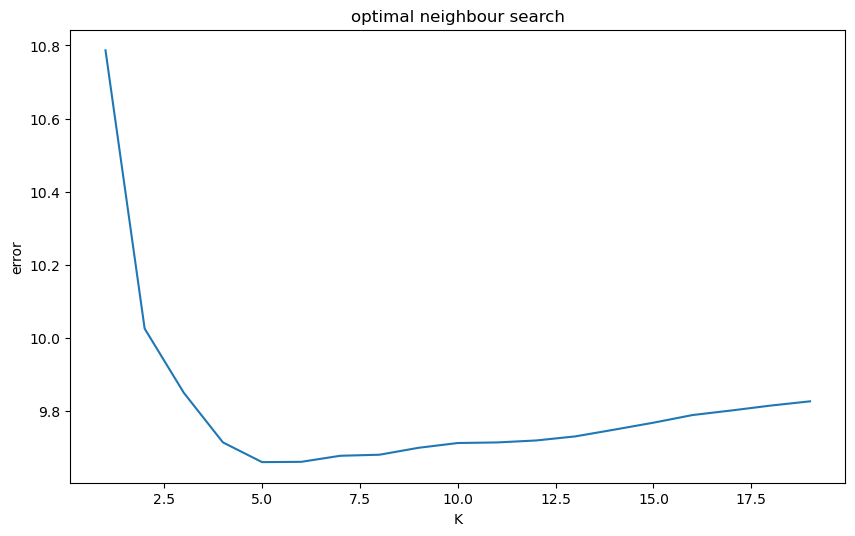

In [14]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(errors.keys(), errors.values())
plt.xlabel('K')
plt.ylabel('error')
plt.title('optimal neighbour search')

# Evaluation

### optimial k =6

In [15]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
y_hat = []
for i in test.index:
    user_i, movie_j = map(int,[test.loc[i]['userId'], 
                               test.loc[i]['movieId']])
    # make the prediction here
    predicted_rating = PredictMovieRating(user_i, 
                                          movie_j, 
                                          correlation_matrix, 
                                          user_movie_rating, 6)
    y_hat.append(predicted_rating)
error_i = error(np.nan_to_num(np.array(y_hat)), y)        


CPU times: user 1min 18s, sys: 187 ms, total: 1min 18s
Wall time: 1min 20s


In [16]:
y= test['rating'].tolist()
# compute error
error(np.nan_to_num(np.array(y_hat)), y)

9.661884022375325

In [17]:
test['prediction'] = y_hat
test.head()

,userId,movieId,rating,prediction
29251,212,69757,3.5,0.000000
97472,654,110,4.5,2.707674
2803,17,1721,0.5,0.403911
44667,313,500,3.5,3.206228
39127,285,2371,4.0,0.582303


In [18]:
one_user= test.loc[(test['userId'] == 19)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
3156,19,162,5.0,0.000000
3416,19,1208,5.0,2.959105
3194,19,306,5.0,4.093172
3270,19,515,5.0,1.566520
3434,19,1231,5.0,0.000000


### Recall and Precision

In [123]:
relevance_threshold = 2
recommended_movies = set(one_user.loc[(one_user['prediction'] >= relevance_threshold)]['movieId'].tolist())
relavent_movies = set(one_user.loc[(one_user['rating'] >= relevance_threshold)]['movieId'].tolist())
len(relavent_movies), len(recommended_movies)

(74, 16)

In [124]:
recommended_movies_intersection_relavant_movies = [i for i in recommended_movies if i in relavent_movies]
recommended_movies_intersection_relavant_movies;

In [125]:
recall = len(recommended_movies_intersection_relavant_movies)/len(relavent_movies)
precision = len(recommended_movies_intersection_relavant_movies)/len(recommended_movies)

In [126]:
len(recommended_movies), len(recommended_movies_intersection_relavant_movies), len(relavent_movies)

(16, 16, 74)

In [127]:
precision, recall

(1.0, 0.21621621621621623)

In [128]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.35555555555555557

### Recall@k and Precision@k

In [136]:
k=18
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
top_k_predictions_df.head()

,userId,movieId,rating,prediction
3341,19,924,4.0,4.330468
3290,19,589,3.0,3.496374
3466,19,1276,4.0,3.345124
3420,19,1213,5.0,3.194447
3198,19,318,4.0,3.144046


In [137]:
relevance_threshold=2
top_k_movies_recommended = set(top_k_predictions_df.loc[(top_k_predictions_df['prediction'] >= relevance_threshold)]['movieId'].tolist())
top_k_movies_relevant = set(top_k_predictions_df.loc[(top_k_predictions_df['rating'] >= relevance_threshold)]['movieId'].tolist())
# top_k_predictions_df['rating']

In [138]:
recommended_movies_intersection_relavant_movies = [i for i in top_k_movies_recommended
                                                   if i in top_k_movies_relevant]
recommended_movies_intersection_relavant_movies;

In [139]:
len(top_k_movies_recommended), len(recommended_movies_intersection_relavant_movies), len(top_k_movies_relevant)

(16, 16, 18)

In [143]:
if len(top_k_movies_relevant)!=0:
    recall = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_relevant)
else:
    recall = 1
if len(top_k_movies_recommended)!=0:
    precision = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_recommended)
else:
    precision = 1

In [144]:
precision, recall

(1.0, 0.8888888888888888)

In [145]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.9411764705882353

### Making top k predictions

In [22]:
one_user= test.loc[(test['userId'] == 20)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
3591,20,2690,5.0,0.000000
3604,20,6201,4.5,NaN
3597,20,3406,4.5,0.000000
3546,20,457,4.5,1.168727
3601,20,5380,4.0,0.000000


In [26]:
movie_meta_data_PATH= "movies_metadata.csv"
movie_df = pd.read_csv(movie_meta_data_PATH, sep= ",") # taking 100000 user-movie rating tuples
movie_df.head()

/home/ac-optimus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [27]:
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
a=top_k_predictions_df['movieId'].unique().tolist()

In [28]:
[movie_df[movie_df.id== str(i)].title.item() for i in a if str(i) in movie_df.id.tolist()]

['Sissi',
 'Three Colors: Red',
 'Terminator 3: Rise of the Machines',
 'Lost in Translation',
 'Titanic',
 'License to Wed',
 'Irma la Douce',
 'More About the Children of Noisy Village',
 'Murder She Said',
 'Cousin, Cousine',
 'The Thomas Crown Affair',
 'The Good Shepherd']